## Quick Look Snapshoot

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import pathlib
import sys
import argparse
import warnings
import h5py
import numpy as np
import yt
import matplotlib
import time
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib import rcParams
import multiprocessing
from multiprocessing import Process, Lock, Array
from pathlib import Path

sys.path.append("/Users/hyw/erm/ppscript/vis/python/") # local
sys.path.append("/home/emost/codes/athenak/vis/python/") # server: anta

import bin_convert as bc
import athena_read

plt.style.use('ncr-paper.mplstyle')
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Computer Modern Sans Serif"]})

In [ ]:
directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/mhdtest/bin/')
directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/mhdtest/bin/')
extension = '.bin'

for file_path in directory_path.iterdir():
    if file_path.is_file() and file_path.suffix == extension:
        print(file_path)
        binary_fname = str(file_path)
        athdf_fname = binary_fname.replace(".bin", ".athdf")
        xdmf_fname = athdf_fname + ".xdmf"
        filedata = bc.read_binary(binary_fname)


In [3]:
tstathdf = '/Users/hyw/Desktop/ERM/athenak-erm/build-mdisk/src/mhdtest/bin/cbd.mhd_w_bcc.02330.athdf'
# tstathdf = '/Users/hyw/CBD_Summit/cbd.mhd_w_bcc.00020.athdf'
# tstathdf = '/Users/hyw/24.6.1-test/cbd.mhd_w_bcc.00008.athdf'
# tstathdf = '/Users/hyw/athenak/hydro-test/src/testmb/lowreso/cbd.mhd_w_bcc.00215.athdf'

Rfig=20.0
tst_athdf = athena_read.athdf(filename=tstathdf,x1_min=-Rfig,x1_max=Rfig, x2_min=-Rfig, x2_max=Rfig, x3_min=-Rfig, x3_max=Rfig)
tst_athdf.keys()

dict_keys(['Coordinates', 'DatasetNames', 'Header', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'dens', 'velx', 'vely', 'velz', 'eint', 'bcc1', 'bcc2', 'bcc3'])

In [4]:
tst = tst_athdf

# initialize the data (read-in)
# time = tst['time']
xdat = tst['x1v']
ydat = tst['x2v']
zdat = tst['x3v']
dens = tst['dens']
eint = tst['eint']
bcc1 = tst['bcc1']
bcc2 = tst['bcc2']
bcc3 = tst['bcc3']
vx = tst['velx']
vy = tst['vely']
vz = tst['velz']

z, y, x = np.meshgrid(zdat, ydat, xdat, indexing='ij')
print('shape of the data is: ', np.shape(x))

nx, ny, nz = np.shape(x)


# index of the center of the domain (index truncation)
xs, xe, ys, ye, zs, ze = nx//4, nx//4*3, ny//4, ny//4*3, nz//4, nz//4*3
# xs, xe, ys, ye, zs, ze = nx//8*3, nx//8*5, ny//8*3, ny//8*5, nz//8*3, nz//8*5
# xs, xe, ys, ye, zs, ze = nx//16*7, nx//16*9, ny//16*7, ny//16*9, nz//16*7, nz//16*9
# xs, xe, ys, ye, zs, ze = nx//32*15, nx//32*17, ny//32*15, ny//32*17, nz//32*15, nz//32*17
# xs, xe, ys, ye, zs, ze = nx//64*31, nx//64*33, ny//64*31, ny//64*33, nz//64*31, nz//64*33   
# xs, xe, ys, ye, zs, ze = nx//128*63, nx//128*65, ny//128*63, ny//128*65, nz//128*63, nz//128*65

nx_tst, ny_tst, nz_tst = xe-xs, ye-ys, ze-zs

# truncated coordinates and mesh data
x_tst = x[xs:xe,ys:ye,zs:ze]
y_tst = y[xs:xe,ys:ye,zs:ze]
z_tst = z[xs:xe,ys:ye,zs:ze]

xdat_tst = xdat[xs:xe]
ydat_tst = ydat[xs:xe]
zdat_tst = zdat[xs:xe]

# truncate the data to only the inner region
dens_tst = dens[xs:xe,ys:ye,zs:ze]
eint_tst = eint[xs:xe,ys:ye,zs:ze]
bcc1_tst = bcc1[xs:xe,ys:ye,zs:ze]
bcc2_tst = bcc2[xs:xe,ys:ye,zs:ze]
bcc3_tst = bcc3[xs:xe,ys:ye,zs:ze]
vx_tst = vx[xs:xe,ys:ye,zs:ze]
vy_tst = vy[xs:xe,ys:ye,zs:ze]
vz_tst = vz[xs:xe,ys:ye,zs:ze]

# reformulate the data into cyl coordinates
darray_tst = [dens_tst, eint_tst, bcc1_tst, bcc2_tst, bcc3_tst, vx_tst, vy_tst, vz_tst]

print('shape of the truncated data is: ', np.shape(x_tst))
# print('rad array: ', rad)


shape of the data is:  (1024, 1024, 1024)
shape of the truncated data is:  (512, 512, 512)


## Density Snapshot (Zoom-in)

2.5
5.0
10.0


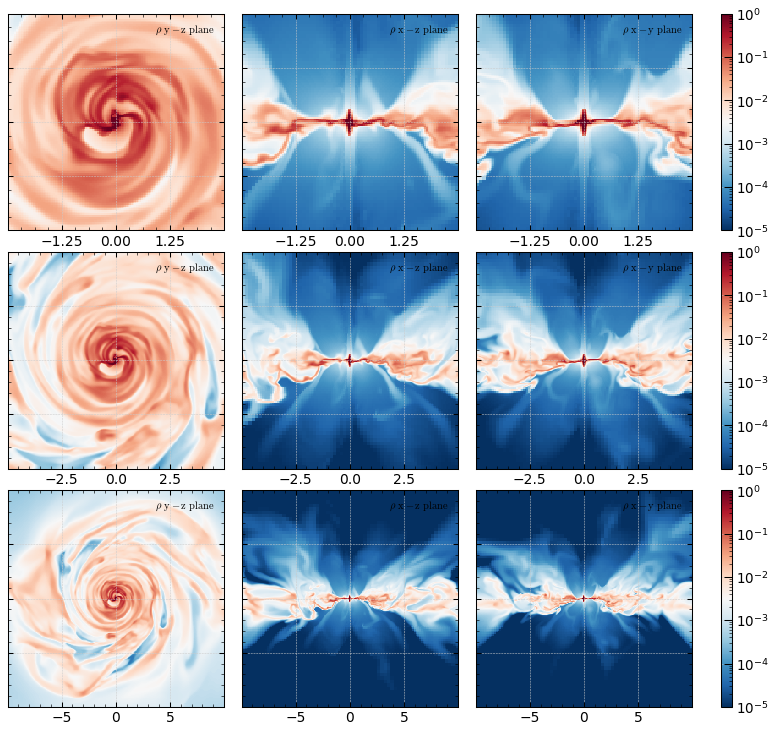

In [6]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12.5, 12),dpi=75)
gs = GridSpec(nrows=3, ncols=5, wspace=0.1, hspace=0.1, width_ratios=[1,1,1,0.0,0.05], height_ratios=[1,1,1])
ax_fig = np.array([[fig.add_subplot(gs[j,i]) for i in range(3)] for j in range(3)])
# ax_fig = ax_fig.flatten()
ax_cbar = np.array([fig.add_subplot(gs[i,4]) for i in range(3)]).flatten()

zmid = nz_tst//2
ymid = ny_tst//2
xmid = nx_tst//2

vmin,vmax = 1e-5,1.0
quant = dens_tst
FigID = r'$\rho$'

RRange_list = np.array([2.5,5.0,10.0])
for iRange,RRange in enumerate(RRange_list):
    ax = ax_fig[iRange,:]
    
    axz = ax[0]
    axy = ax[1]
    axx = ax[2]
    print(RRange)
    Rticks = np.arange(-RRange+RRange/2,RRange,RRange/2)
    Rticklabels = np.array([str(i) for i in Rticks])
    
    imz = axz.pcolormesh(x_tst[zmid,:,:],y_tst[zmid,:,:],quant[zmid,:,:],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{x-y \ plane}$')
    imy = axy.pcolormesh(x_tst[:,ymid,:],z_tst[:,ymid,:],quant[:,ymid,:],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{x-z \ plane}$')
    imx = axx.pcolormesh(y_tst[:,:,xmid],z_tst[:,:,xmid],quant[:,:,xmid],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{y-z \ plane}$')
    
    patchz = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{x-y \ plane}$')
    patchy = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{x-z \ plane}$')
    patchx = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{y-z \ plane}$')
    
    axx.legend(handles=[patchz],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    axy.legend(handles=[patchy],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    axz.legend(handles=[patchx],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    
    for idirec in range(3):
        ax[idirec].set_xlim(-RRange,RRange)
        ax[idirec].set_ylim(-RRange,RRange)

        ax[idirec].set_xticks(Rticks)
        # ax[idirec].set_xticklabels([])
        ax[idirec].set_yticks(Rticks)
        ax[idirec].set_yticklabels([])
        ax[idirec].set_aspect("equal")

    cax1 = ax_cbar[iRange]
    cax1.tick_params(which='major',direction='in',labelsize=13,length=7.5,labelleft=True,labelright=False)
    cax1.tick_params(which='minor',direction='in')
    cax1.yaxis.set_minor_locator(mticker.MultipleLocator(0.5))
    colorbar1 = plt.colorbar(imz,cax=cax1)
plt.savefig('./test-den.png',dpi=250)

## Velocity Snapshot

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12.5, 12),dpi=75)
gs = GridSpec(nrows=3, ncols=5, wspace=0.1, hspace=0.1, width_ratios=[1,1,1,0.0,0.05], height_ratios=[1,1,1])
ax_fig = np.array([[fig.add_subplot(gs[j,i]) for i in range(3)] for j in range(3)])
# ax_fig = ax_fig.flatten()
ax_cbar = np.array([fig.add_subplot(gs[i,4]) for i in range(3)]).flatten()

zmid = nz_tst//2
ymid = ny_tst//2
xmid = nx_tst//2

vmin,vmax = 1e-5,1.0
quant = dens_tst
FigID = r'$\rho$'

RRange_list = np.array([2.5,5.0,10.0])
for iRange,RRange in enumerate(RRange_list):
    ax = ax_fig[iRange,:]
    
    axz = ax[0]
    axy = ax[1]
    axx = ax[2]
    print(RRange)
    Rticks = np.arange(-RRange+RRange/2,RRange,RRange/2)
    Rticklabels = np.array([str(i) for i in Rticks])
    
    imz = axz.pcolormesh(x_tst[zmid,:,:],y_tst[zmid,:,:],quant[zmid,:,:],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{x-y \ plane}$')
    imy = axy.pcolormesh(x_tst[:,ymid,:],z_tst[:,ymid,:],quant[:,ymid,:],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{x-z \ plane}$')
    imx = axx.pcolormesh(y_tst[:,:,xmid],z_tst[:,:,xmid],quant[:,:,xmid],cmap='RdBu_r',norm=colors.LogNorm(vmin=vmin, vmax=vmax),label=FigID+r' $\mathrm{y-z \ plane}$')
    
    patchz = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{x-y \ plane}$')
    patchy = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{x-z \ plane}$')
    patchx = mpatches.Patch(color=None,alpha=0.0, label=FigID+r' $\mathrm{y-z \ plane}$')
    
    axx.legend(handles=[patchz],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    axy.legend(handles=[patchy],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    axz.legend(handles=[patchx],loc='upper right',frameon=False,fontsize=10,labelcolor='black')
    
    for idirec in range(3):
        ax[idirec].set_xlim(-RRange,RRange)
        ax[idirec].set_ylim(-RRange,RRange)

        ax[idirec].set_xticks(Rticks)
        # ax[idirec].set_xticklabels([])
        ax[idirec].set_yticks(Rticks)
        ax[idirec].set_yticklabels([])
        ax[idirec].set_aspect("equal")

    cax1 = ax_cbar[iRange]
    cax1.tick_params(which='major',direction='in',labelsize=13,length=7.5,labelleft=True,labelright=False)
    cax1.tick_params(which='minor',direction='in')
    cax1.yaxis.set_minor_locator(mticker.MultipleLocator(0.5))
    colorbar1 = plt.colorbar(imz,cax=cax1)
plt.savefig('./test-den.png',dpi=250)

In [ ]:

# Execute main function
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('data_file',
                        help='name of input file, possibly including path')
    parser.add_argument('quantity',
                        help='name of quantity to be plotted')
    parser.add_argument('output_file',
                        help=('name of output to be (over)written, possibly including '
                              'path; use "show" to show interactive plot instead'))
    parser.add_argument('--vmin',
                        type=float,
                        default=None,
                        help=('data value to correspond to colormap minimum; use '
                              '--vmin=<val> if <val> has negative sign'))
    parser.add_argument('--vmax',
                        type=float,
                        default=None,
                        help=('data value to correspond to colormap maximum; use '
                              '--vmax=<val> if <val> has negative sign'))
#     parser.add_argument('-d', '--direction',
#                         type=int,
#                         choices=(1, 2, 3),
#                         default=3,
#                         help=('direction orthogonal to slice for 3D data'))
#     parser.add_argument('--slice_location',
#                         type=float,
#                         default=None,
#                         help=('coordinate value along which slice is to be taken '
#                               '(default: 0)'))
#     parser.add_argument('-a', '--average',
#                         action='store_true',
#                         help=('flag indicating averaging should be done in orthogonal '
#                               'direction for 3D data'))
#     parser.add_argument('-s', '--sum',
#                         action='store_true',
#                         help=('flag indicating summation should be done in orthogonal '
#                               'direction for 3D data'))
#     parser.add_argument('-l',
#                         '--level',
#                         type=int,
#                         default=None,
#                         help=('refinement level to be used in plotting (default: max '
#                               'level in file)'))
#     parser.add_argument('--x_min',
#                         type=float,
#                         default=None,
#                         help='minimum extent of plot in first plotted direction')
#     parser.add_argument('--x_max',
#                         type=float,
#                         default=None,
#                         help='maximum extent of plot in first plotted direction')
#     parser.add_argument('--y_min',
#                         type=float,
#                         default=None,
#                         help='minimum extent of plot in second plotted direction')
#     parser.add_argument('--y_max',
#                         type=float,
#                         default=None,
#                         help='maximum extent of plot in second plotted direction')
#     parser.add_argument('-f', '--fill',
#                         action='store_true',
#                         help='flag indicating image should fill plot area, even if this '
#                              'distorts the aspect ratio')
#     parser.add_argument('-c',
#                         '--colormap',
#                         default=None,
#                         help=('name of Matplotlib colormap to use instead of default'))
#     parser.add_argument('--logc',
#                         action='store_true',
#                         help='flag indicating data should be colormapped logarithmically')
#     parser.add_argument('--stream',
#                         default=None,
#                         help='name of vector quantity to use to make stream plot')
#     parser.add_argument('--stream_average',
#                         action='store_true',
#                         help='flag indicating stream plot should be averaged in '
#                              'orthogonal direction for 3D data')
#     parser.add_argument('--stream_density',
#                         type=float,
#                         default=1.0,
#                         help='density of stream lines')
    args = parser.parse_args()
    main(**vars(args))


In [ ]:
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
from mpi4py import MPI
# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


rad = (np.sqrt(xdat_tst**2 + ydat_tst**2))
theta = np.arctan2(ydat_tst, xdat_tst)
z = zdat_tst

rad_ = np.linspace(0, np.max(rad), len(xdat_tst))
theta_ = np.linspace(0, 2*np.pi, len(rad_))
z_ = np.linspace(np.min(z), np.max(z), len(rad_))

''''
    Off-center grid for mini-disk diagnostics
'''
'''
rad_ = np.linspace(0, np.max(rad), len(xdat_tst))
theta_ = np.linspace(0, 2*np.pi, len(rad_))
z_ = np.linspace(np.min(z), np.max(z), len(rad_))
'''

ZZ_grid, THETA_grid, RAD_grid  = np.meshgrid(z_, theta_, rad_, indexing='ij')
X_target, Y_target, Z_target = RAD_grid*np.cos(THETA_grid), RAD_grid*np.sin(THETA_grid), ZZ_grid

cart_points = np.vstack((xdat_tst, ydat_tst, zdat_tst)).T 
# cyl_points = np.vstack((rad, theta,z)).T

# Determine the portion of the grid each process will handle
num_points = X_target.size
points_per_proc = num_points // size
start_idx = rank * points_per_proc
end_idx = (rank + 1) * points_per_proc if rank != size - 1 else num_points

print('rank:', rank, 'start_idx:', start_idx, 'end_idx:', end_idx)
print(np.shape(Z_target))
print(np.shape(x_tst.flatten()))
print(np.shape(dens_tst.flatten()))

def cyl_interp(quantity_tst, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points):
    # Each process handles a portion of the interpolation
    quantity_tst_partial = griddata((z_tst.flatten(), y_tst.flatten(), x_tst.flatten()), quantity_tst.flatten(),
                            (Z_target.flatten()[start_idx:end_idx], Y_target.flatten()[start_idx:end_idx], X_target.flatten()[start_idx:end_idx]),
                            method='linear')

    # Gather the partial results from all processes
    quantity_tst_full = None
    if rank == 0:
        quantity_tst_full = np.empty(num_points, dtype=quantity_tst_partial.dtype)
    comm.Gather(quantity_tst_partial, quantity_tst_full, root=0)

    # Plot the results (only rank 0)
    if rank == 0:
        quantity_tst_full = quantity_tst_full.reshape(RAD_grid.shape)
        
    return quantity_tst_full

# test the interpolation (density)
dens_tst_full = cyl_interp(dens_tst, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points)

# darray_tst_full = []
# for idarray, darray in enumerate(darray_tst):
#     darray_tst_full.append(cyl_interp(darray, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points))
#     print('current array: ', idarray, ' in total: ', len(darray_tst))




tauI = RegularGridInterpolator((np.log(T[0]),np.log(n[0])),
            np.log(tau_pi), bounds_error=False, fill_value=None,method='linear')
    tempD = np.reshape(np.log(T), (nm))
    rhoD = np.reshape(np.log(r), (nm))
    pointsI = [(a,b) for a,b in zip(tempD,rhoD)]
    res = np.exp(zI(pointsI))

In [107]:
import numpy as np
from scipy.interpolate import *
import matplotlib.pyplot as plt
from mpi4py import MPI
# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


rad = (np.sqrt(xdat_tst**2 + ydat_tst**2))
theta = np.arctan2(ydat_tst, xdat_tst)
z = zdat_tst

rad_ = np.linspace(0, np.max(rad), len(xdat_tst))
theta_ = np.linspace(0, 2*np.pi, len(rad_))
z_ = np.linspace(np.min(z), np.max(z), len(rad_))

''''
    Off-center grid for mini-disk diagnostics
'''

'''
rad_ = np.linspace(0, np.max(rad), len(xdat_tst))
theta_ = np.linspace(0, 2*np.pi, len(rad_))
z_ = np.linspace(np.min(z), np.max(z), len(rad_))

'''





ZZ_grid, THETA_grid, RAD_grid  = np.meshgrid(z_, theta_, rad_, indexing='ij')
X_target, Y_target, Z_target = RAD_grid*np.cos(THETA_grid), RAD_grid*np.sin(THETA_grid), ZZ_grid

cart_points = np.vstack((xdat_tst, ydat_tst, zdat_tst)).T 
# cyl_points = np.vstack((rad, theta,z)).T

# Determine the portion of the grid each process will handle
num_points = X_target.size
points_per_proc = num_points // size
start_idx = rank * points_per_proc
end_idx = (rank + 1) * points_per_proc if rank != size - 1 else num_points




# def cyl2cart(rad, theta, z):
#     x = rad * np.cos(theta)
#     y = rad * np.sin(theta)
#     z = z
#     return x, y, z

# x_grid, y_grid, z_grid = cyl2cart(rad, theta, z)
# X_grid, Y_grid, Z_grid = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')
# rad_grid, theta_grid, zz_grid = np.meshgrid(rad, theta, z, indexing='ij')
# grid_points = np.vstack((x_grid.flatten(), y_grid.flatten(), z_grid.flatten())).T


# dens_tst = griddata((x_tst.flatten(), y_tst.flatten(), z_tst.flatten()), dens_tst.flatten(), (X_target,Y_target,Z_target), method='linear')


print('rank:', rank, 'start_idx:', start_idx, 'end_idx:', end_idx)
print(np.shape(Z_target))
print(np.shape(x_tst.flatten()))
print(np.shape(dens_tst.flatten()))

def cyl_interp(quantity_tst, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points):
    # Each process handles a portion of the interpolation
    quantity_tst_partial = griddata((z_tst.flatten(), y_tst.flatten(), x_tst.flatten()), quantity_tst.flatten(),
                            (Z_target.flatten()[start_idx:end_idx], Y_target.flatten()[start_idx:end_idx], X_target.flatten()[start_idx:end_idx]),
                            method='linear')

    # Gather the partial results from all processes
    quantity_tst_full = None
    if rank == 0:
        quantity_tst_full = np.empty(num_points, dtype=quantity_tst_partial.dtype)
    comm.Gather(quantity_tst_partial, quantity_tst_full, root=0)

    # Plot the results (only rank 0)
    if rank == 0:
        quantity_tst_full = quantity_tst_full.reshape(RAD_grid.shape)
        
    return quantity_tst_full

# test the interpolation (density)
# dens_tst_full = cyl_interp(dens_tst, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points)

darray_tst_full = []
for idarray, darray in enumerate(darray_tst):
    darray_tst_full.append(cyl_interp(darray, x_tst, y_tst, z_tst, X_target, Y_target, Z_target, start_idx, end_idx, rank, num_points))
    print('current array: ', idarray, ' in total: ', len(darray_tst))


        # fig = plt.figure(figsize=(8, 8))
        # ax = fig.add_subplot(111, polar=True)
        # c = ax.contourf(THETA_grid[0,:,:], RAD_grid[0,:,:], dens_tst_full[8,:,:], 50, cmap='viridis')
        # fig.colorbar(c)

        # plt.title('Interpolated Data on Cylindrical Grid')
        # plt.show()

# def cyl_intp(dat_tst, xdat_tst, ydat_tst, zdat_tst):
#   interp_func = RegularGridInterpolator((zdat_tst, ydat_tst, xdat_tst), dat_tst, method='linear')
#   # interpolated_values = griddata(cart_points, dat_tst.flatten(), grid_points, method='linear')
#   # interpolated_values = interpolated_values.reshape(r.shape)
#   # np.shape(interp_data((X_grid,Y_grid,Z_grid)))
#   # Plotting the results
#   interp_data = interp_func((Z_grid,Y_grid,X_grid))
#   return interp_data

# dens_= (cyl_intp(dens_tst, xdat_tst, ydat_tst, zdat_tst))
# eint_= cyl_intp(eint_tst, xdat_tst, ydat_tst, zdat_tst)
# bcc1_= cyl_intp(bcc1_tst, xdat_tst, ydat_tst, zdat_tst)
# bcc2_= cyl_intp(bcc2_tst, xdat_tst, ydat_tst, zdat_tst)
# bcc3_= cyl_intp(bcc3_tst, xdat_tst, ydat_tst, zdat_tst)
# vx_= cyl_intp(vx_tst, xdat_tst, ydat_tst, zdat_tst)
# vy_= cyl_intp(vy_tst, xdat_tst, ydat_tst, zdat_tst)
# vz_= cyl_intp(vz_tst, xdat_tst, ydat_tst, zdat_tst)

# vrad_ = np.sqrt(vx_**2 + vy_**2)
# vtheta_ = np.arctan2(vy_, vx_)
# vp_ = np.sqrt(vrad_**2 + vtheta_**2)

# brad_ = np.sqrt(bcc1_**2 + bcc2_**2)
# btheta_ = np.arctan2(bcc2_, bcc1_)
# bp_ = np.sqrt(brad_**2 + btheta_**2)
# bz_ = bcc3_

# vAp_ = np.sqrt((brad_**2 + btheta_**2)/dens_)
# vA_ = np.sqrt((bcc1_**2 + bcc2_**2 + bcc3_**2)/dens_)
# vF_ =  

rank: 0 start_idx: 0 end_idx: 262144
(64, 64, 64)
(262144,)
(262144,)
current array:  0  in total:  8
current array:  1  in total:  8
current array:  2  in total:  8
current array:  3  in total:  8
current array:  4  in total:  8
current array:  5  in total:  8
current array:  6  in total:  8
current array:  7  in total:  8


In [2]:
dens_tst_full = np.array(darray_tst_full[0])
eint_tst_full = np.array(darray_tst_full[1])
bcc1_tst_full = np.array(darray_tst_full[2])
bcc2_tst_full = np.array(darray_tst_full[3])
bcc3_tst_full = np.array(darray_tst_full[4])
vx_tst_full = np.array(darray_tst_full[5])
vy_tst_full = np.array(darray_tst_full[6])
vz_tst_full = np.array(darray_tst_full[7])

vrad_tst_full = np.sqrt(vx_tst_full**2 + vy_tst_full**2)
vz_tst_full = vz_tst_full
brad_tst_full = np.sqrt(bcc1_tst_full**2 + bcc2_tst_full**2)
bz_tst_full = bcc3_tst_full

vp_tst_full = np.sqrt(vrad_tst_full**2 + vz_tst_full**2)
vAp_tst_full = np.sqrt((brad_tst_full**2 + bz_tst_full**2)/dens_tst_full)
vA_tst_full = np.sqrt((bcc1_tst_full**2 + bcc2_tst_full**2 + bcc3_tst_full**2)/dens_tst_full)
cs = np.sqrt(1.4*eint_tst_full/dens_tst_full)
vF_tst_full = np.sqrt(0.5*(vA_tst_full**2+cs**2)+0.5*np.sqrt((vA_tst_full**2+cs**2)**2-4*cs**2*vA_tst_full**2))

np.shape(dens_tst_full)



NameError: name 'np' is not defined

In [1]:
diff_vA = vAp_tst_full - vp_tst_full
diff_vF = vA_tst_full - vF_tst_full


dens_tst_full = dens_tst_full.reshape(RAD_grid.shape)
diff_vA = diff_vA.reshape(RAD_grid.shape)
diff_vF = diff_vF.reshape(RAD_grid.shape)

fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, polar=True)
# c = ax.contourf(THETA_grid[0,:,:], RAD_grid[0,:,:], np.average(dens_tst_full[:,:,:],axis=0), 50, vmax=0.07,vmin=1e-5,cmap='viridis')
ax = fig.add_subplot(111, polar=False)
c = ax.pcolormesh(RAD_grid[:,0,:], ZZ_grid[:,0,:], np.average(vrad_tst_full[:,:,:],axis=1),  vmax=1,vmin=1e-5,cmap='viridis')
fig.colorbar(c)
ax.contour(RAD_grid[:,0,:], ZZ_grid[:,0,:], np.average(diff_vA,axis=1), levels=[0], colors='red', linewidths=2)
# ax.contour(RAD_grid[:,0,:], ZZ_grid[:,0,:], np.average(diff_vF,axis=1), levels=[0], colors='blue', linewidths=2)
ax.contour(RAD_grid[:,0,:], ZZ_grid[:,0,:], np.average(dens_tst_full,axis=1), levels=[0.1], colors='magenta', linewidths=2)


plt.title('Interpolated Data on Cylindrical Grid')
plt.show()



NameError: name 'vAp_tst_full' is not defined

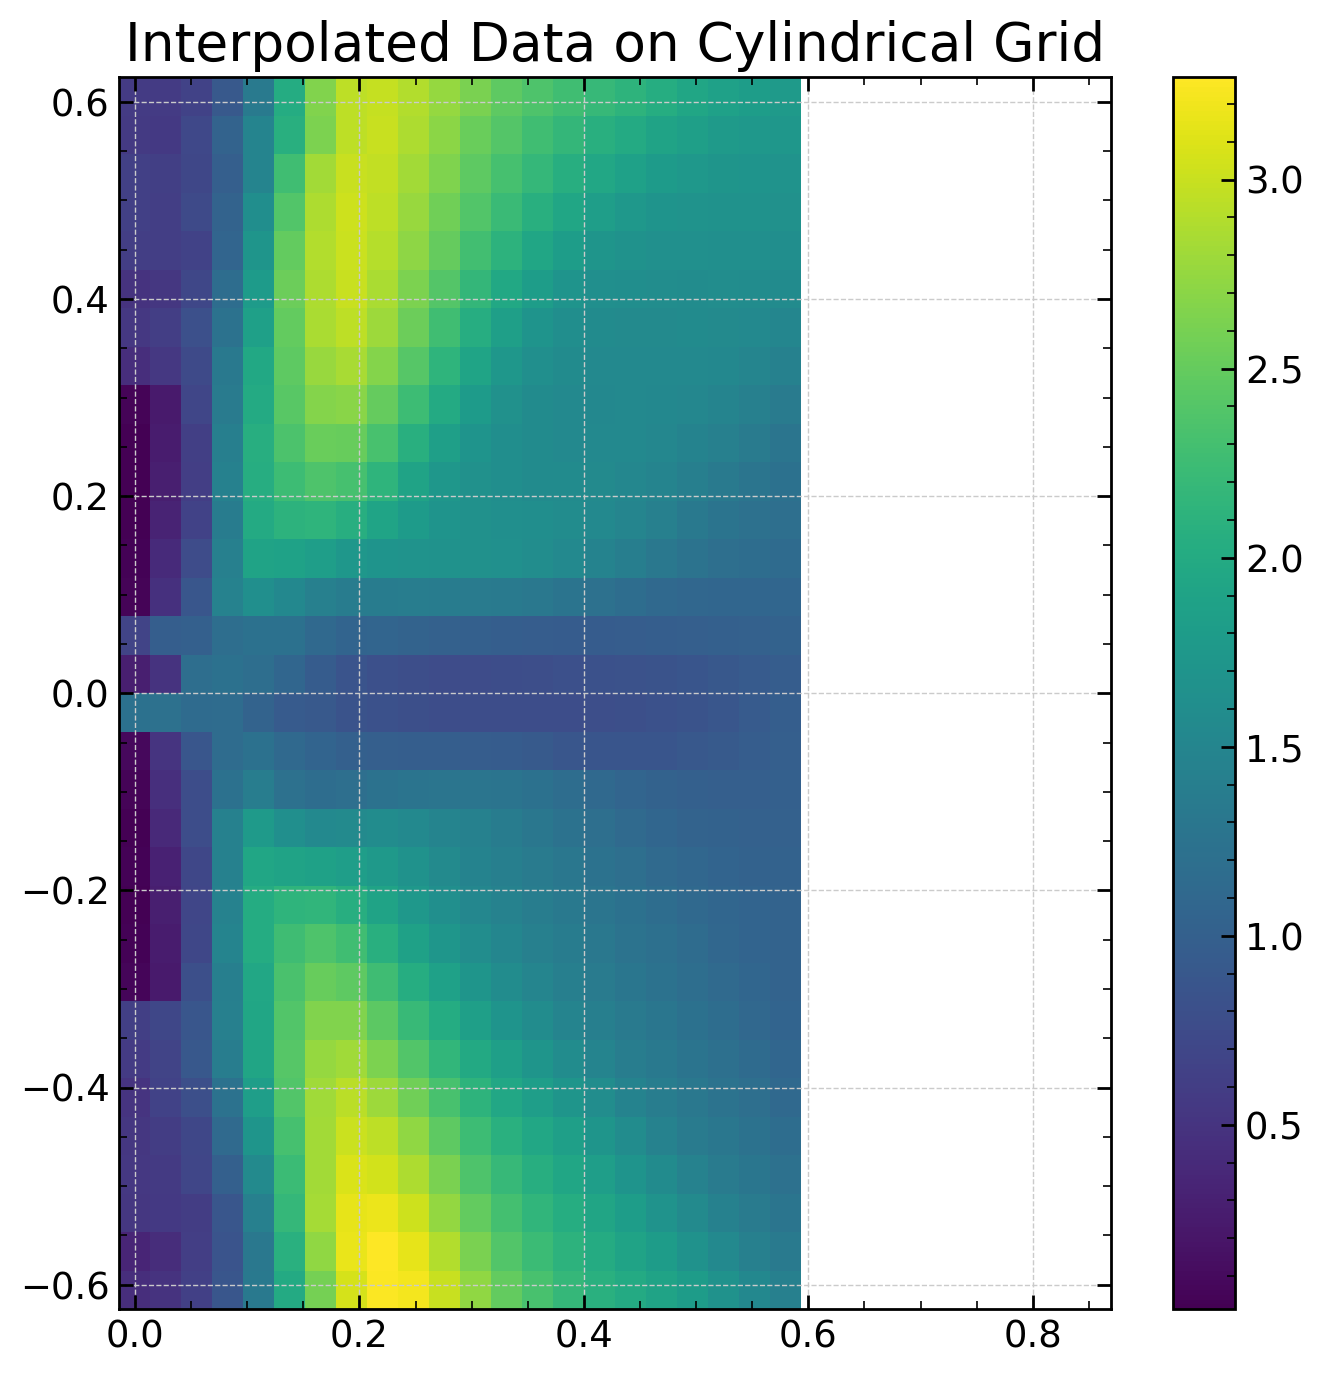

In [95]:

dens_tst_full = dens_tst_full.reshape(RAD_grid.shape)
fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, polar=True)
# c = ax.contourf(THETA_grid[0,:,:], RAD_grid[0,:,:], np.average(dens_tst_full[:,:,:],axis=0), 50, vmax=0.07,vmin=1e-5,cmap='viridis')
ax = fig.add_subplot(111, polar=False)
c = ax.pcolormesh(RAD_grid[:,0,:], ZZ_grid[:,0,:], np.average(vrad_tst_full[:,:,:],axis=1),  vmax=1,vmin=1e-5,cmap='viridis')
fig.colorbar(c)
plt.title('Interpolated Data on Cylindrical Grid')
plt.show()

## Example script for making the interpolation onto a cylindrical grid

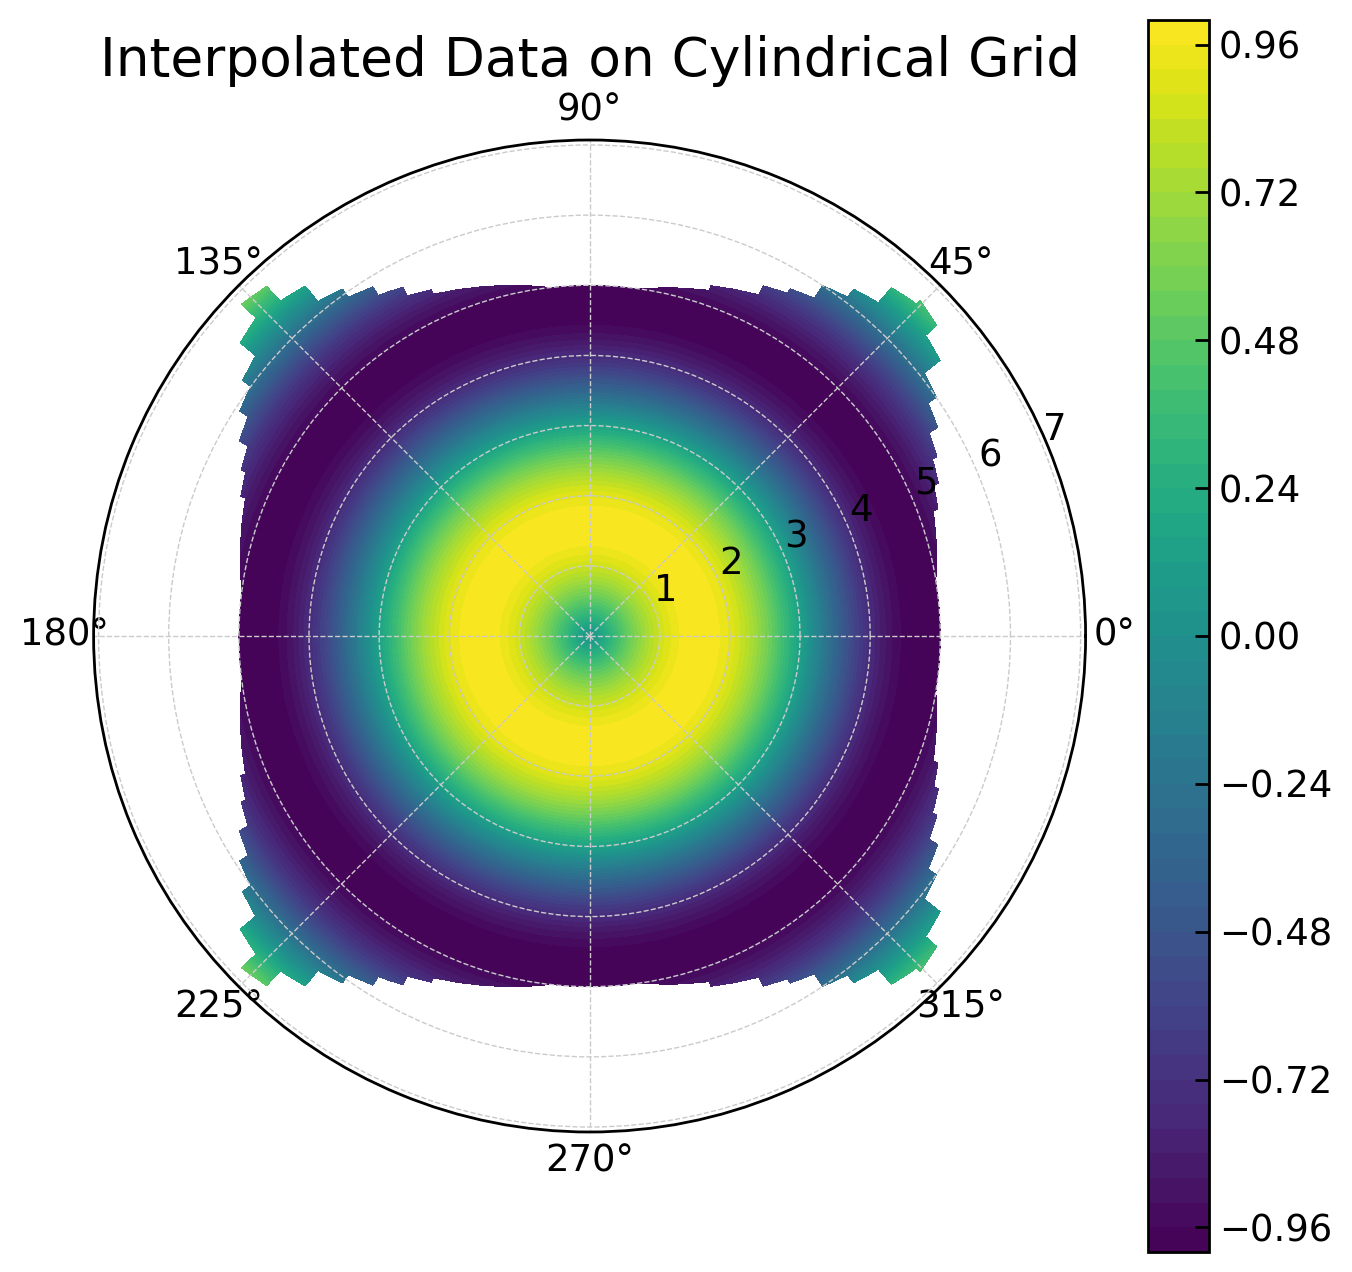

In [13]:
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Create a Cartesian grid (example)
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Example data on the Cartesian grid
Z = np.sin(np.sqrt(X**2 + Y**2))

# Convert Cartesian coordinates to cylindrical coordinates
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Define the target cylindrical grid
r = np.linspace(0, np.max(R), 100)
theta = np.linspace(-np.pi, np.pi, 100)
R_target, Theta_target = np.meshgrid(r, theta)

# Convert the target cylindrical grid to Cartesian coordinates
X_target = R_target * np.cos(Theta_target)
Y_target = R_target * np.sin(Theta_target)

# Determine the portion of the grid each process will handle
num_points = X_target.size
points_per_proc = num_points // size
start_idx = rank * points_per_proc
end_idx = (rank + 1) * points_per_proc if rank != size - 1 else num_points

# Each process handles a portion of the interpolation
Z_target_partial = griddata((X.flatten(), Y.flatten()), Z.flatten(),
                            (X_target.flatten()[start_idx:end_idx], Y_target.flatten()[start_idx:end_idx]),
                            method='linear')

# Gather the partial results from all processes
Z_target_full = None
if rank == 0:
    Z_target_full = np.empty(num_points, dtype=Z_target_partial.dtype)
comm.Gather(Z_target_partial, Z_target_full, root=0)

# Plot the results (only rank 0)
if rank == 0:
    Z_target_full = Z_target_full.reshape(R_target.shape)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    c = ax.contourf(Theta_target, R_target, Z_target_full, 50, cmap='viridis')
    fig.colorbar(c)

    plt.title('Interpolated Data on Cylindrical Grid')
    plt.show()


In [82]:
# interp_data_aziave = np.average(interp_data, axis = 1)
dens_aziave = np.average(dens_, axis = 1)
brad_aziave = np.average(brad_, axis = 1)
btheta_aziave = np.average(btheta_, axis = 1)
bp_aziave = np.average(bp_, axis = 1)
bz_aziave = np.average(bz_, axis = 1)

/var/folders/vg/zvs06sj138zdhlws5nv25dph0000gn/T/ipykernel_1557/3858478183.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Rad_grid[:,128,:], ZZ_grid[:,128,:], dens_[:,128,:]


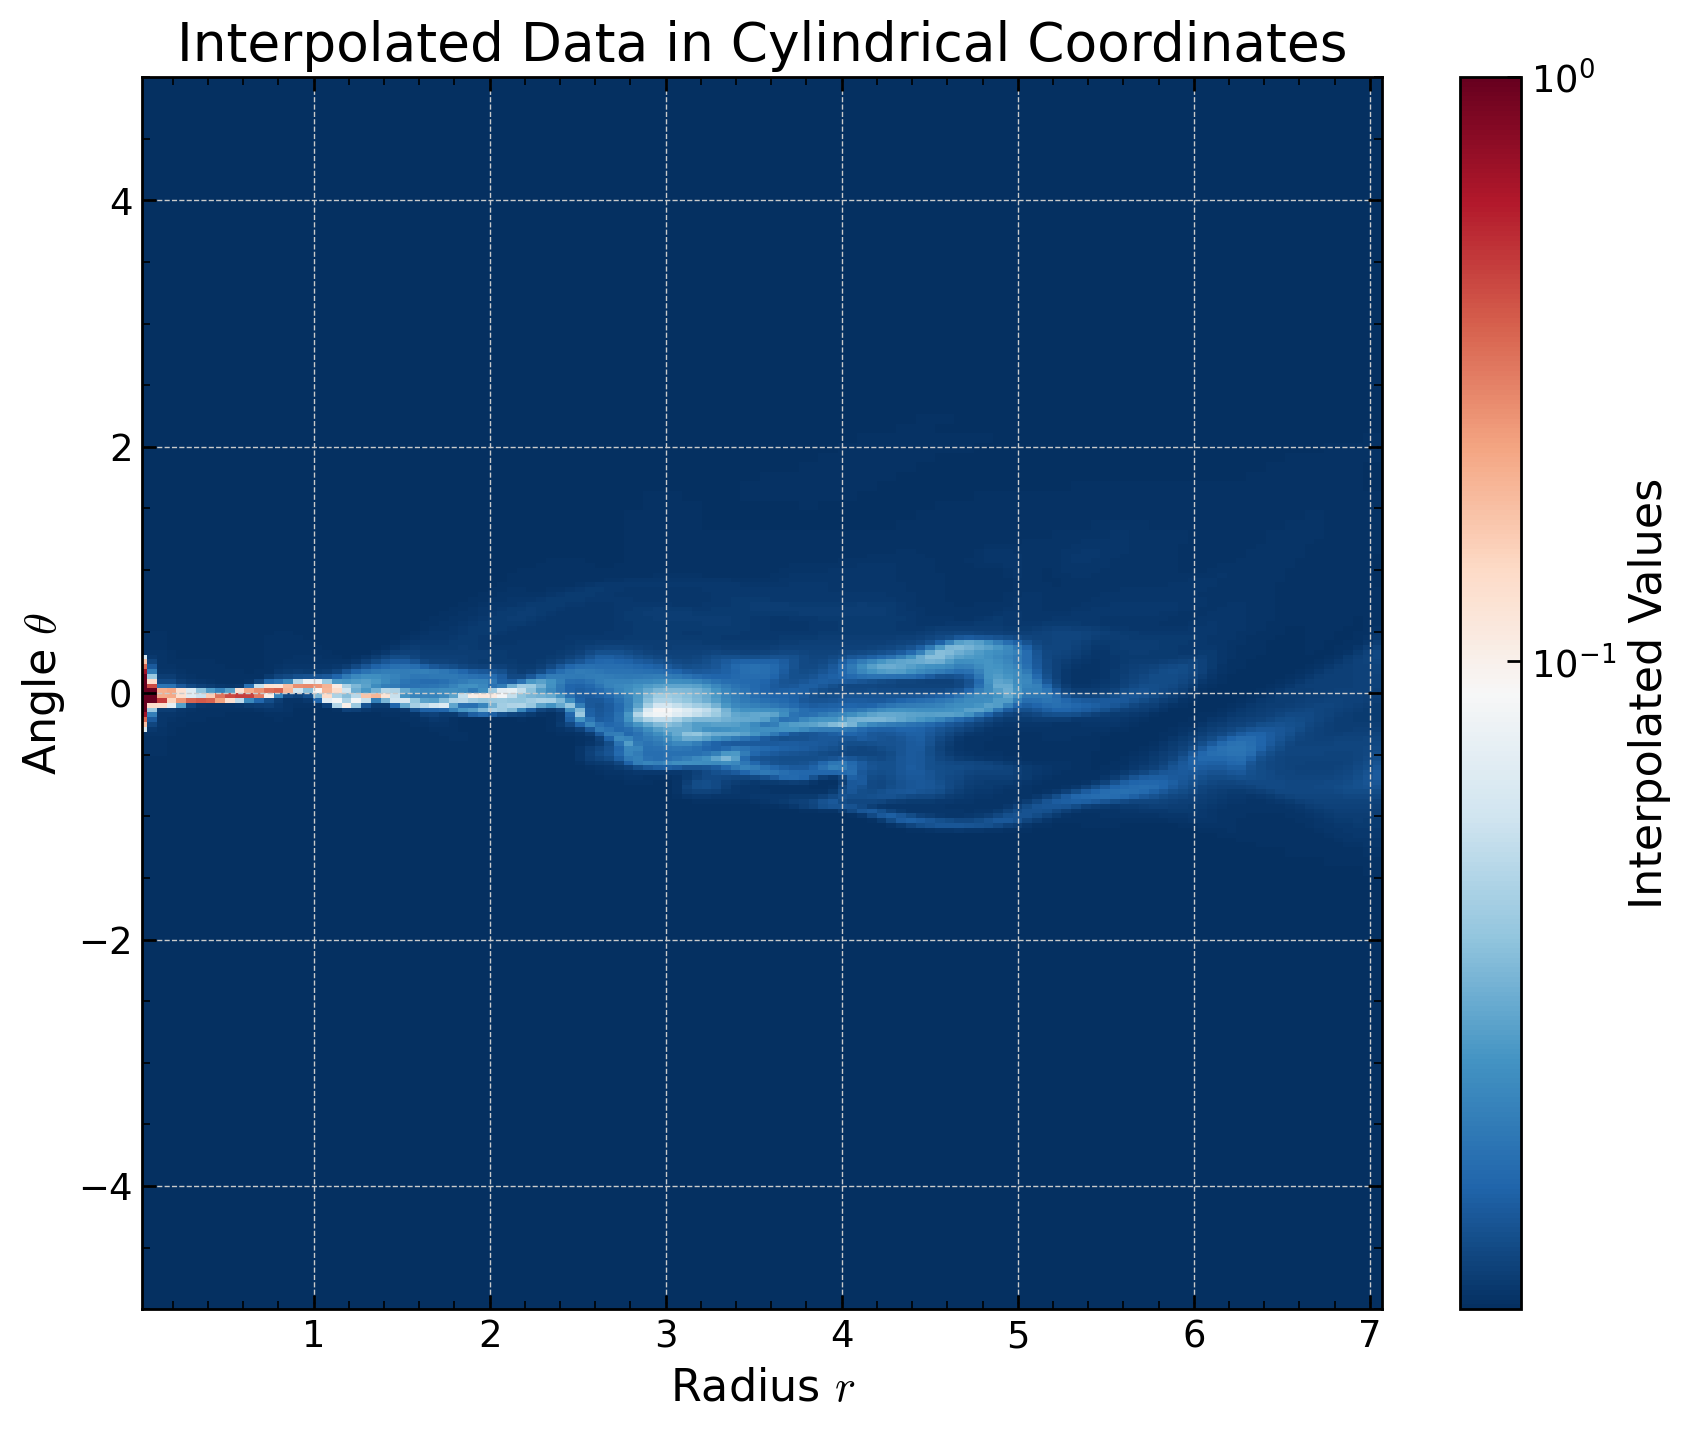

In [134]:
plt.figure(figsize=(10, 8))

plt.pcolormesh(Rad_grid[:,128,:], ZZ_grid[:,128,:], dens_[:,128,:]
               ,norm=colors.SymLogNorm(linthresh=1e-1),cmap='RdBu_r', shading='auto')
# plt.pcolormesh(X_grid[:,:,128], Y_grid[:,:,128], interp_data[128,:,:]
#                ,norm=colors.SymLogNorm(linthresh=1e-1),cmap='RdBu_r', shading='auto')
# plt.streamplot(Rad_grid[:,128,:], ZZ_grid[:,128,:], brad_aziave, bz_aziave , color='g')
plt.colorbar(label='Interpolated Values')
plt.xlabel('Radius $r$')
plt.ylabel('Angle $\\theta$')
plt.title('Interpolated Data in Cylindrical Coordinates')
plt.show()

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1010101010101D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.2020202020202D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.2020202020202D+00


/var/folders/vg/zvs06sj138zdhlws5nv25dph0000gn/T/ipykernel_1557/2834456741.py:8: RuntimeWarning: invalid value encountered in scalar divide
  u = -np.sin(theta) / r
/var/folders/vg/zvs06sj138zdhlws5nv25dph0000gn/T/ipykernel_1557/2834456741.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  v = np.cos(theta) / r


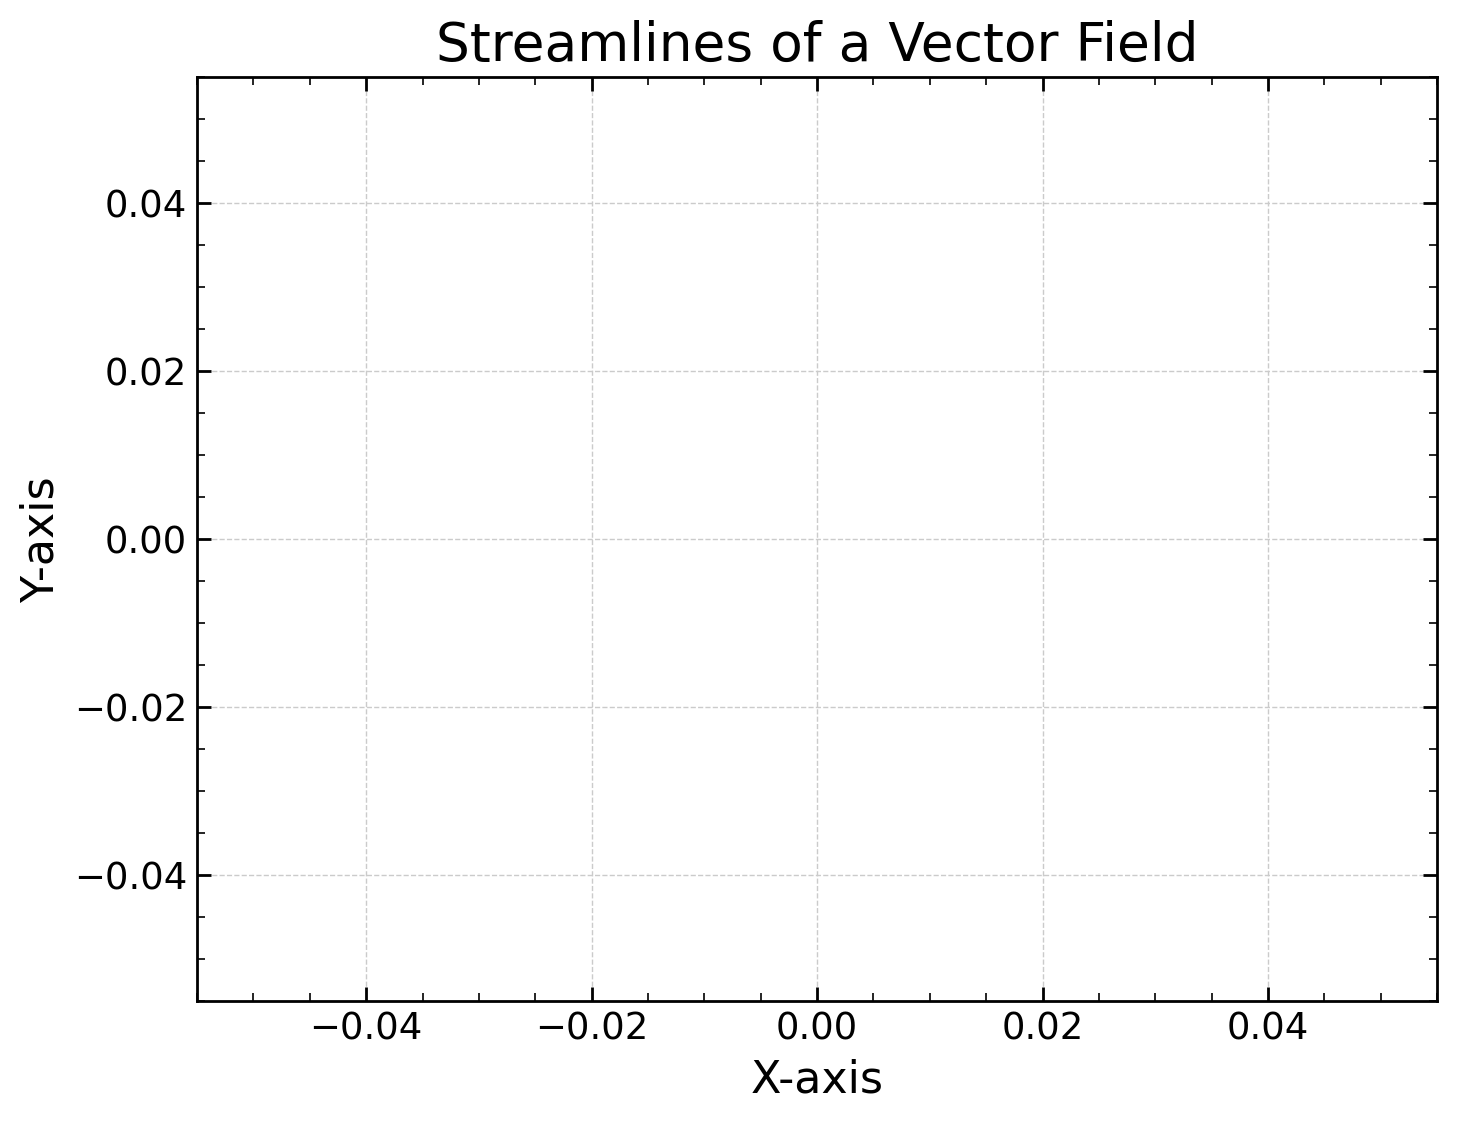

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def vector_field(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    u = -np.sin(theta) / r
    v = np.cos(theta) / r
    return u, v

def compute_streamlines(x_range, y_range, resolution):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U, V = vector_field(X, Y)
    
    def streamline_equation(s, t):
        x, y = s
        dxdt, dydt = vector_field(x, y)
        return [dxdt, dydt]
    
    start_points = [[0, 0]]
    streamlines = []
    
    for start in start_points:
        s = odeint(streamline_equation, start, np.linspace(0, 10, 100))
        streamlines.append(s)
    
    return streamlines

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Compute streamlines
streamlines = compute_streamlines([-3, 3], [-3, 3], 100)

# Plot each streamline
for streamline in streamlines:
    ax.plot(streamline[:, 0], streamline[:, 1], color='blue')

# Add a title and labels
ax.set_title('Streamlines of a Vector Field')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

# Show plot
plt.show()


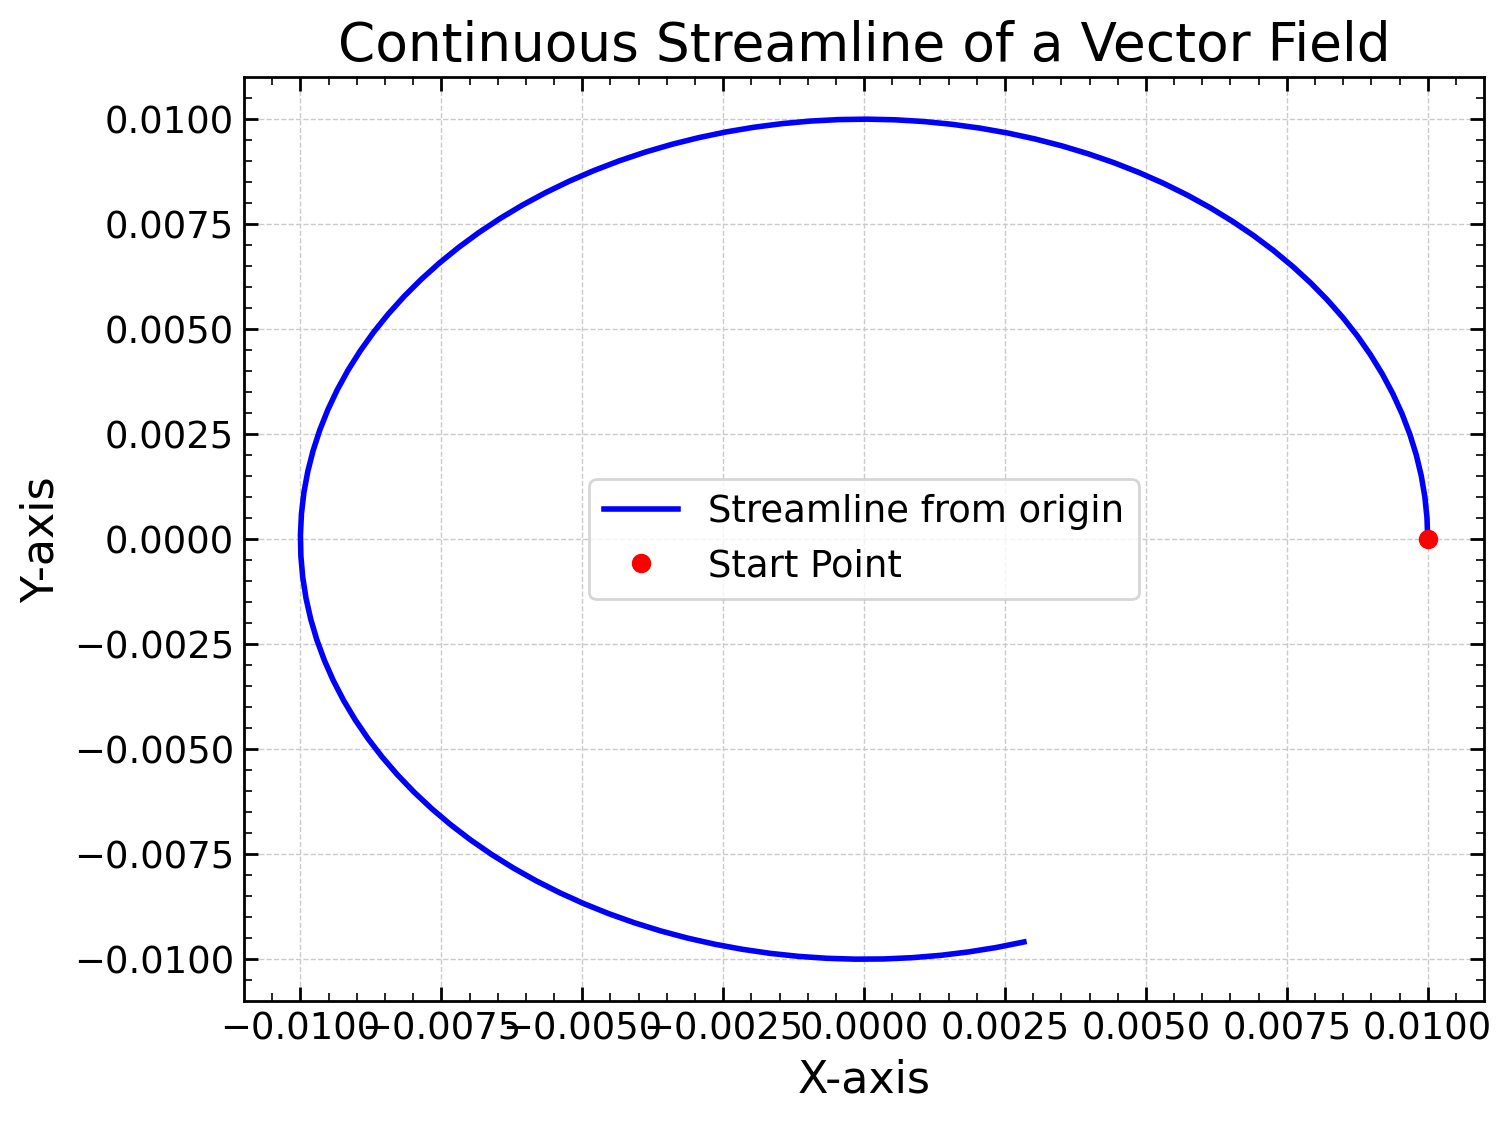

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the vector field function
def vector_field(x, y):
    u = -y  # Example vector field component in x direction
    v = x   # Example vector field component in y direction
    return u, v

# Define the streamline computation function
def compute_streamline(start_point, dt=0.05, num_steps=100):
    # Define the ODE system for the vector field
    def ode_system(s, t):
        x, y = s
        u, v = vector_field(x, y)
        return [u, v]
    
    # Integrate the ODE system to compute the streamline
    t = np.linspace(0, num_steps * dt, num_steps)
    s = odeint(ode_system, start_point, t)
    return s

# Set up the plot
plt.figure(figsize=(8, 6))

# Define start point (e.g., origin)
start_point = [0.01, 0]

# Compute the streamline
streamline = compute_streamline(start_point)

# Plot the streamline
plt.plot(streamline[:, 0], streamline[:, 1], color='blue', label='Streamline from origin')

# Plot the starting point (optional)
plt.plot(start_point[0], start_point[1], 'ro', label='Start Point')

# Add a title, labels, legend, and grid
plt.title('Continuous Streamline of a Vector Field')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

# Show plot
plt.show()



In [18]:
# doing the interpolation from cartesian coord to cylindrical coord and spherical coord
def cart2cyl(data_cart, x, y, z):
    # Cylindrical coordinates
    r_cyl = np.sqrt(x**2 + y**2)
    phi_cyl = np.arctan2(y, x)
    z_cyl = z

    nz_cart, ny_cart, nx_cart = np.shape(data_cart)
    nz_cyl, nr_cyl, nphi_cyl = nz_cart, ny_cart, nx_cart


    # Output arrays for the new coordinates
    data_cyl = np.zeros_like(data_cart)

    # Assume bx_cyl and bx_sph are calculated somehow; for now, we just copy bx
    data_cyl = data_cart

    # If you want to extrapolate bx to the new coordinates, you need an interpolation method
    from scipy.interpolate import RegularGridInterpolator

    # Interpolators for the original Cartesian data
    interpolator_cartesian = RegularGridInterpolator((zdat, ydat, xdat), data_cart)

    # Create new coordinate grid for interpolation
    cyl_points = np.array([z_cyl.flatten(), r_cyl.flatten(), phi_cyl.flatten()]).T

    # Interpolate to get the new bx values in cylindrical and spherical coordinates
    data_cyl = interpolator_cartesian(cyl_points).reshape((nz_cyl, nr_cyl, nphi_cyl))
    return r_cyl, phi_cyl, z_cyl, data_cyl


def cart2sph(data_cart, x, y, z):
    # Spherical coordinates
    r_sph = np.sqrt(x**2 + y**2 + z**2)
    theta_sph = np.arccos(z / r_sph)
    phi_sph = np.arctan2(y, x)
    
    # Output arrays for the new coordinates
    data_sph = np.zeros_like(data_cart)
    
    # Assume bx_cyl and bx_sph are calculated somehow; for now, we just copy bx
    data_sph = data_cart
    
    # If you want to extrapolate bx to the new coordinates, you need an interpolation method
    from scipy.interpolate import RegularGridInterpolator
    
    # Interpolators for the original Cartesian data
    interpolator_cartesian = RegularGridInterpolator((zdat, ydat, xdat), data_cart)
    
    # Create new coordinate grid for interpolation
    sph_points = np.array([r_sph.flatten(), theta_sph.flatten(), phi_sph.flatten()]).T
    
    # Interpolate to get the new bx values in cylindrical and spherical coordinates
    data_sph = interpolator_cartesian(sph_points).reshape((1024, 1024, 1024))
    return r_sph, theta_sph, phi_sph, data_sph



In [24]:
from mpi4py import MPI
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def cart2cyl(data_cart, x, y, z, xdat, ydat, zdat):
    # Cylindrical coordinates
    r_cyl = np.sqrt(x**2 + y**2)
    phi_cyl = np.arctan2(y, x)
    z_cyl = z

    # Interpolators for the original Cartesian data
    interpolator_cartesian = RegularGridInterpolator((zdat, ydat, xdat), data_cart)

    # Create new coordinate grid for interpolation
    cyl_points = np.array([z_cyl.flatten(), r_cyl.flatten(), phi_cyl.flatten()]).T

    # Interpolate to get the new data values in cylindrical coordinates
    data_cyl = interpolator_cartesian(cyl_points).reshape(data_cart.shape)
    return r_cyl, phi_cyl, z_cyl, data_cyl

def cart2sph(data_cart, x, y, z, xdat, ydat, zdat):
    # Spherical coordinates
    r_sph = np.sqrt(x**2 + y**2 + z**2)
    theta_sph = np.arccos(z / r_sph)
    phi_sph = np.arctan2(y, x)

    # Interpolators for the original Cartesian data
    interpolator_cartesian = RegularGridInterpolator((zdat, ydat, xdat), data_cart)

    # Create new coordinate grid for interpolation
    sph_points = np.array([r_sph.flatten(), theta_sph.flatten(), phi_sph.flatten()]).T

    # Interpolate to get the new data values in spherical coordinates
    data_sph = interpolator_cartesian(sph_points).reshape(data_cart.shape)
    return r_sph, theta_sph, phi_sph, data_sph

# Assuming tst_athdf is already loaded and available
tst = tst_athdf

# Extract the coordinate and data arrays
xdat = tst['x1v']
ydat = tst['x2v']
zdat = tst['x3v']
dens = tst['dens']

# Generate the 3D meshgrid for coordinates
z, y, x = np.meshgrid(zdat, ydat, xdat, indexing='ij')
print('Shape of the data is:', np.shape(x))

# Split the data across processes
nz, ny, nx = np.shape(x)
n_per_proc = nz // size
zdat_local = zdat[rank * n_per_proc:(rank + 1) * n_per_proc]
z_local, y_local, x_local = np.meshgrid(zdat_local, ydat, xdat, indexing='ij')
dens_local = np.empty((n_per_proc, ny, nx))

comm.Scatter(dens, dens_local, root=0)

# Perform coordinate transformation and interpolation locally
r_cyl, phi_cyl, z_cyl, dens_cyl_local = cart2cyl(dens_local, x_local, y_local, z_local, xdat, ydat, zdat)
r_sph, theta_sph, phi_sph, dens_sph_local = cart2sph(dens_local, x_local, y_local, z_local, xdat, ydat, zdat)

# Gather the results back to rank 0
dens_cyl = None
dens_sph = None
if rank == 0:
    dens_cyl = np.empty((nz, ny, nx))
    dens_sph = np.empty((nz, ny, nx))

comm.Gather(dens_cyl_local, dens_cyl, root=0)
comm.Gather(dens_sph_local, dens_sph, root=0)

# Now rank 0 has the full dens_cyl and dens_sph arrays
if rank == 0:
    print("Cylindrical conversion complete. Shape:", dens_cyl.shape)
    print("Spherical conversion complete. Shape:", dens_sph.shape)


# r_cyl, phi_cyl, z_cyl, rho_cyl = cart2cyl(dat_tst, x_tst, y_tst, z_tst)

Shape of the data is: (1024, 1024, 1024)


: 

(100,)


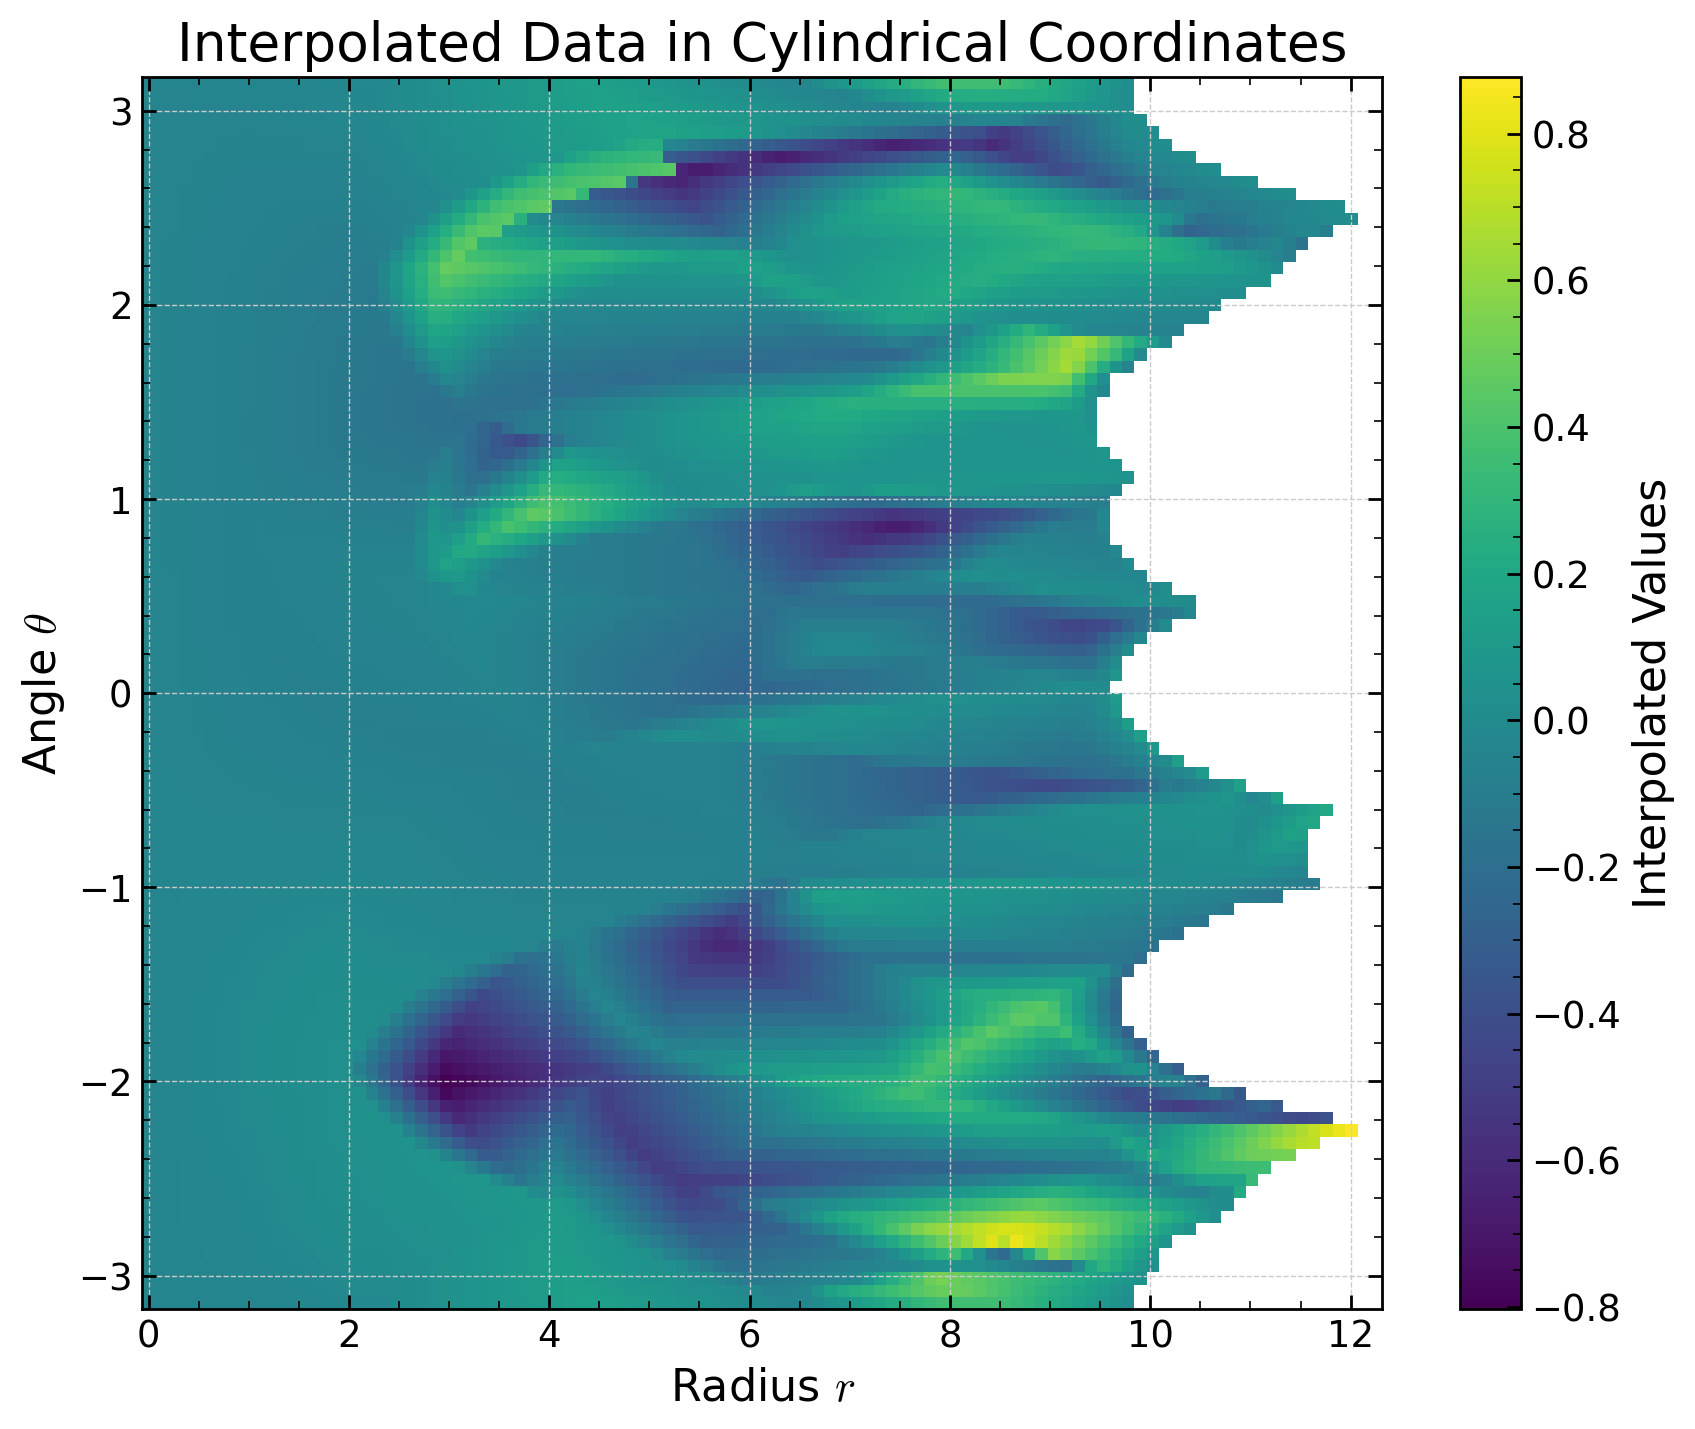

In [20]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Example data in Cartesian coordinates
np.random.seed(0)  # For reproducibility
x = np.random.uniform(-10, 10, 100)
y = np.random.uniform(-10, 10, 100)
z = np.random.uniform(-10, 10, 100)
values = np.sin(x) * np.cos(y) * np.sin(z)  # Some function for the example
print(np.shape(values))
# Convert Cartesian to Cylindrical coordinates
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)

# Define the cylindrical coordinate grid 
# Interpolation
cartesian_points = np.vstack((x, y)).T
cylindrical_points = np.vstack((r.flatten(), theta.flatten())).T

# Function to convert cylindrical to Cartesian for interpolation
def cylindrical_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

X_grid, Y_grid = cylindrical_to_cartesian(R, Theta)
grid_points = np.vstack((X_grid.flatten(), Y_grid.flatten())).T

# Interpolate using griddata
interpolated_values = griddata(cartesian_points, values, grid_points, method='linear')
interpolated_values = interpolated_values.reshape(R.shape)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.pcolormesh(R, Theta, interpolated_values, shading='auto')
plt.colorbar(label='Interpolated Values')
plt.xlabel('Radius $r$')
plt.ylabel('Angle $\\theta$')
plt.title('Interpolated Data in Cylindrical Coordinates')
plt.show()

In [8]:
def SQR(x):
    return np.square(x)
gamma=5.0/3.0
beta = 2.0*(eint*(gamma-1.0))/(SQR(bcc1)+SQR(bcc2)+SQR(bcc3))

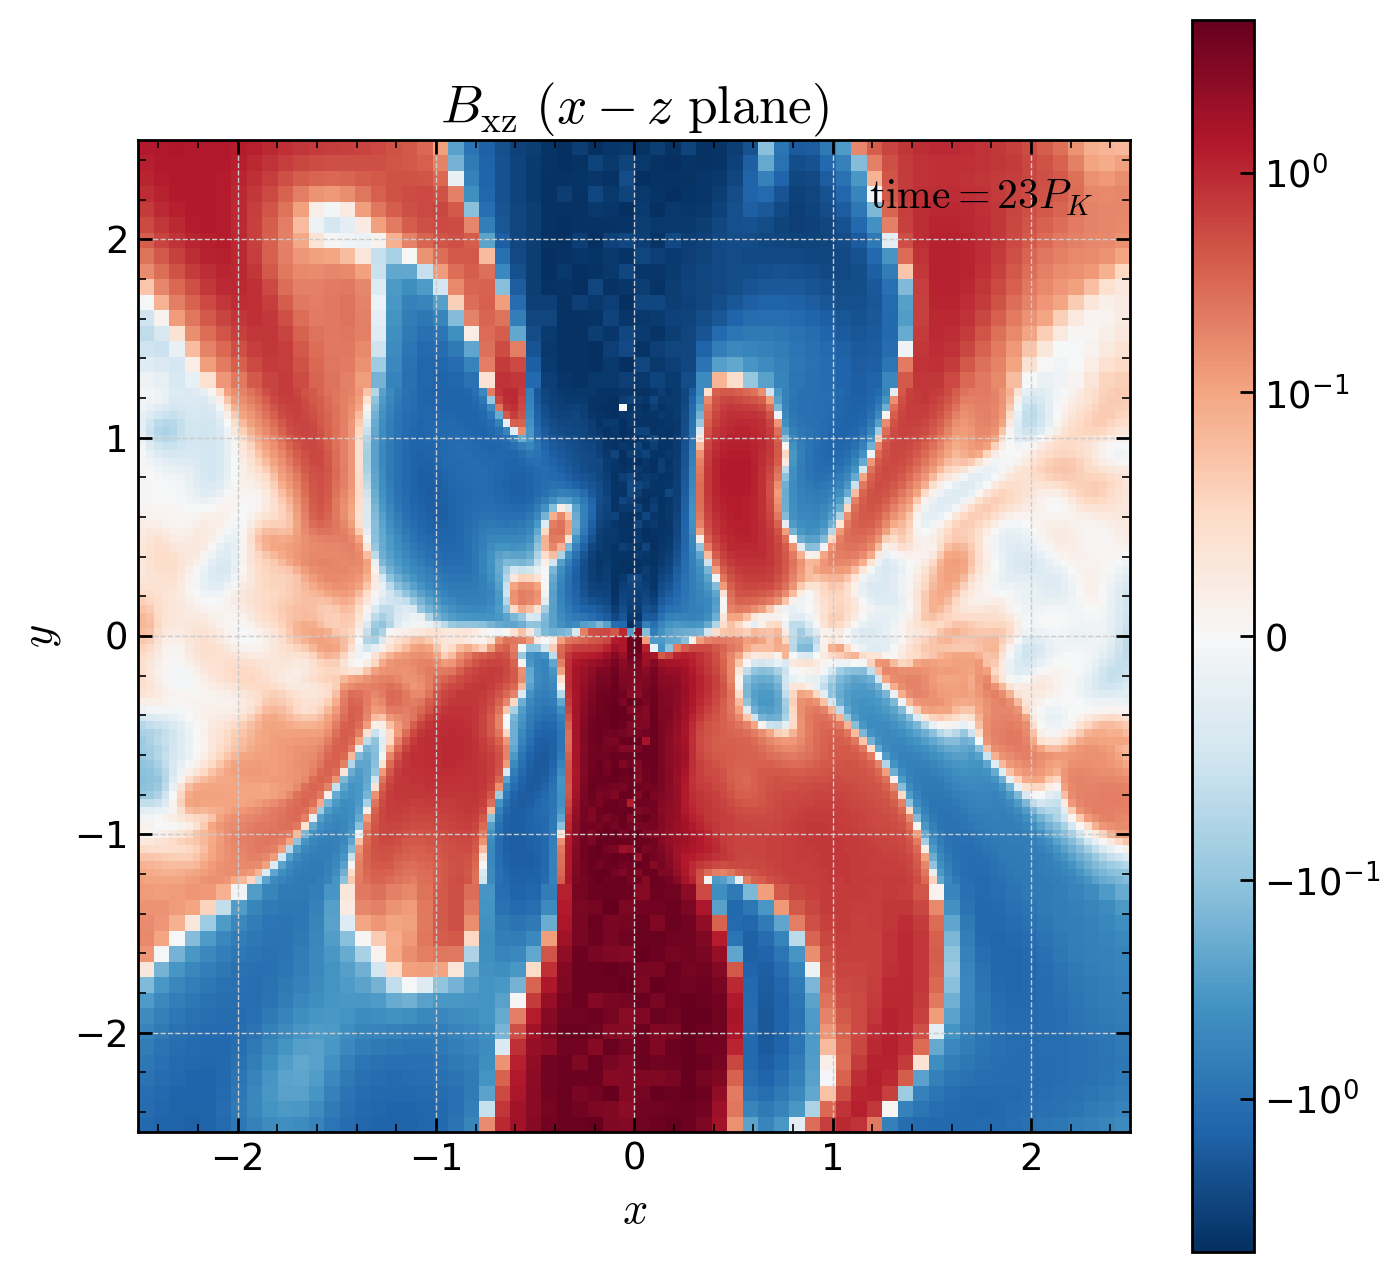

In [49]:
Rplot=2.5
Nint = 512

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_aspect('equal')

# varname='vz'
im = ax.pcolormesh(x[:,Nint,:],z[:,Nint,:], (vz[:,Nint,:]), norm=colors.SymLogNorm(linthresh=1e-1),cmap='RdBu_r', shading='auto')

# varname='dens'
# im = ax.pcolormesh(x[:,Nint,:],z[:,Nint,:], np.log10(dens[:,Nint,:]), norm=colors.SymLogNorm(linthresh=1e-1),cmap='RdBu_r', shading='auto')
varname='dens'
# im = ax.pcolormesh(x[Nint,:,:],y[Nint,:,:], np.log10(dens[Nint,:,:]), 
#                    vmin=-2,vmax=0.2,
#                    cmap='RdBu_r', shading='auto',
#                    )

# varname='beta-vel'
# im = ax.pcolormesh(x[512,:,:],y[512,:,:], np.log10(beta[512,:,:]), 
#                    vmin=-2.5,vmax=1,
#                    cmap='RdBu_r', shading='auto',
#                    )

# # streamline plot fo the magnetic field 
# strm = ax.streamplot(x[512,:,:], y[512,:,:], vx[512,:,:], vy[512,:,:], color='k', linewidth=1.5, density=1.5)


# varname='Bz-bcc'
# im = ax.pcolormesh(x[:,512,:],z[:,512,:], (bcc3[:,512,:]), norm=colors.SymLogNorm(linthresh=1e-3),cmap='RdBu_r', shading='auto')
# strm = ax.quiver(x[:,512,:],z[:,512,:], bcc1[:,512,:], bcc3[:,512,:],pivot='mid', color='k')

ax.set_xlim(-Rplot,Rplot)
ax.set_ylim(-Rplot,Rplot)
ax.set_xlim(-Rplot,Rplot)
ax.set_ylim(-Rplot,Rplot)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

# ax.set_title(r'$\rho_{\mathrm{mid}} \ (x-y \ \mathrm{plane})$')
# ax.set_title(r'$\beta_{\mathrm{mid}} \ (x-y \ \mathrm{plane})$')

ax.set_title(r'$B_{\mathrm{xz}} \ (x-z \ \mathrm{plane})$')

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
        
patch = mpatches.Patch(color=None,alpha=0.0, label=r'$\mathrm{time}=23P_K$')
ax.legend(handles=[patch],loc='upper right', fontsize=15, frameon=False)
plt.colorbar(im)

plt.savefig(f'test-23-{varname}.png',dpi=300)
# im = ax.pcolormesh(x,y, np.log10(dens[:,:,0]), cmap='viridis', shading='auto')

### File Converter: from binary to athdf

In [ ]:
# binary_fname = "/Users/hyw/erm/athena_bhl_test/test-2/torus.mhd_w_bcc.00198.bin"
from pathlib import Path

# directory_path = Path('/Users/hyw/erm/athena_bhl_test/test/')
# directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/out/bin/')
directory_path = Path('/Users/hyw/erm/athena_bhl_test/athenak_lbox-1/')
directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build/src/output/bin/')
directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build/src/1gpu_1orbit/bin/')
directory_path = Path('/Users/hyw/erm/out_2gpu_1000/bin/')
directory_path = Path('/Users/hyw/erm/out_2gpu_wenoz/bin/')
directory_path = Path('/Users/hyw/erm/out_2gpu_llf/bin/')
directory_path = Path('/Users/hyw/erm/rk3_wenoz_hllc_2d/bin/')
directory_path = Path('/Users/hyw/erm/rk3_roe_low_2d/')
directory_path = Path('/Users/hyw/erm/epsilon0.1/')
directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build-scaf/src/out/bin/')
directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build-scaf/src/anta-scaf/')
directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-cbd/src/bin/')
directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/mhdtest/bin/')

# directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/test/bin/')
# directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/cbdi/bin/')
# directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-mdisk/src/cbd-23.3.6-crash_eos/bin/')
# directory_path = Path('/Users/hyw/erm/data/mhdtest/')
# directory_path = Path('/Users/hyw/erm/data/mhdtest-cpu/')
# directory_path = Path('/Users/hyw/Desktop/ERm/athenak-erm/build-scaf/src/anta-scaf/bin/')

# directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build-mdisk/src/cbd/bin')
# directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/build-3dhydro/src/cbd2d/bin')

# directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/2f/src/2f/bin')
# directory_path = Path('/Users/hyw/Desktop/ERM/athenak/fm/src/fmtest/bin')

# directory_path = Path('/Users/hyw/Desktop/ERM/scaf/scaf/src/test/bin')
# directory_path = Path('/Users/hyw/erm/data/scaf/bin')

extension = '.bin'

for file_path in directory_path.iterdir():
    if file_path.is_file() and file_path.suffix == extension:
        print(file_path)
        binary_fname = str(file_path)
        athdf_fname = binary_fname.replace(".bin", ".athdf")
        xdmf_fname = athdf_fname + ".xdmf"
        filedata = bc.read_binary(binary_fname)
        bc.write_athdf(athdf_fname, filedata)
        bc.write_xdmf_for(xdmf_fname, os.path.basename(athdf_fname), filedata)

In [ ]:
M_sun = 1.989e30
G = 6.67430e-11
c = 299792458
AU = 149597870700
pc = 3.085677581467192e16
kpc = 3.085677581467192e19
Mpsr = 1.4 * M_sun
Tpsr = 2.4*60*60 

T_inspiral = (5.0/16.0) *(4*np.pi**2)**1.333 * c**5 * G**(-0.666) * Tpsr**(8.0/3.0) * Mpsr**(-0.666)
T_inspiral = T_inspiral/(60*60*24*365.25)
#/(5.0/256.0)*(c**5/G**3)*(1.0/(np.pi**8))*(M_sun**2/Mpsr**2)*(1.0/AU)**4
print(T_inspiral)

In [ ]:
M_smbh = 1e8 * M_sun
R_smbh = 2.0 * G * M_smbh / c**2
f = np.sqrt(G*M_smbh/R_smbh**3)/np.pi

D = 1e9*kpc
v = np.sqrt(G*M_smbh/R_smbh)
h = (G*M_smbh/c**2) * 1.0/D * (v/c)**2
print (h)

In [ ]:
M_un = c**3/(8**0.5*G*200*np.pi)
print(M_un/M_sun)

In [ ]:
R_un = 2*G*M_un/c**2
Lgw = 8/5.0 * M_un**5/R_un**3 * 4.0*10**38

D_ = 4e3*kpc
LL = Lgw/(D_**2)
print(LL)

In [ ]:
# binary_fname = "/Users/hyw/erm/athena_bhl_test/test-2/torus.mhd_w_bcc.00198.bin"
from pathlib import Path

# directory_path = Path('/Users/hyw/erm/athena_bhl_test/test/')
# directory_path = Path('/Users/hyw/Desktop/ERM/athenak-erm/out/bin/')
directory_path = Path('/Users/hyw/erm/athena_bhl_test/athenak_lbox-1/')
extension = '.bin'

for file_path in directory_path.iterdir():
    if file_path.is_file() and file_path.suffix == extension:
        print(file_path)
        binary_fname = str(file_path)
        athdf_fname = binary_fname.replace(".bin", ".athdf")
        xdmf_fname = athdf_fname + ".xdmf"
        filedata = bc.read_binary(binary_fname)
        bc.write_athdf(athdf_fname, filedata)
        bc.write_xdmf_for(xdmf_fname, os.path.basename(athdf_fname), filedata)

In [ ]:
MDMcc = 2.0*10**30.0*299792458**2
mDMcc = 100*1.60218e-10
print(mDMcc)
N = MDMcc/mDMcc

kpc = 3.086e+19
R = 120*kpc
sigma = 500*1000
trelax = 1.33*N*R/sigma

print(trelax)

In [ ]:
data_dir = "../BH_ac_gcc/plt06053"
# data_dir = "../BH_ac_gcc/plt37695"
# data_dir = "../BH_ac_gcc/chk04000"
# data_dir = "/Users/hyw/Desktop/ERM/GReX/Problems/FUKA_BH_accretion/plt04404"

fields_test = [("RHOSTAR"),("BX"),("BY"),("BZ"),("EPS")]
#fields_all =[("RHOSTAR") ,("TAUENERGY") ,("STX") ,("STY") ,("STZ") ,("YESTAR") ,("SSTAR") ,
#         ("BX") ,("BY") ,("BZ") ,("PHI") ,("ALPHA") ,("BETAX") ,("BETAY") ,("BETAZ") ,
#        #  ("W") ,("GTXX") ,("GTXY") ,("GTXZ") ,("GTYY") ,("GTYZ") ,("GTZZ") ,
#        #  ("ATXX") ,("ATXY") ,("ATXZ") ,("ATYY") ,("ATYZ") ,("ATZZ") ,
#         ("TRK") ,("RHOB") ,("EPS") ,("WVX") ,("WVY") ,("WVZ") ,("YE") ,("SENTROPY")]



In [ ]:
ds = yt.load(data_dir)

max_level = ds.index.max_level

ref = int(np.prod(ds.ref_factors[0:max_level]))
low = ds.domain_left_edge
dims = ds.domain_dimensions * ref
nx, ny, nz = dims
print(dims)

cube = ds.covering_grid(max_level, left_edge=low, dims=dims, fields=fields_test)


rho = cube[("RHOSTAR")].d
bx = cube[("BX")].d
by = cube[("BY")].d
bz = cube[("BZ")].d
eps = cube[("EPS")].d
# rho = cube[irho].d
# u = cube[iu].d
nx, ny, nz = rho.shape
boxl=200

fig, ax = plt.subplots(dpi=150)

plt.P_colormesh(rho[:,:,nz//2], cmap="RdBu_r",norm=colors.LogNorm())
plt.xlim(nx//2-boxl, nx//2+boxl)
plt.ylim(ny//2-boxl, ny//2+boxl)
ax.set_aspect('equal')


In [ ]:
ds['STX']

In [ ]:

region = ds.all_data()
seed_points = [region.center]
field = "BZ"  

# Calculate streamlines
# streamlines = yt.streamlines.Streamlines(ds, seed_points, field)

# Plot the streamlines
fig, ax = plt.subplots(figsize=(8, 8))

plt.streamplot(x,y,bx,by)


In [ ]:
print(seed_points)

In [ ]:
ds = yt.load(data_dir)

max_level = ds.index.max_level

ref = int(np.prod(ds.ref_factors[0:max_level]))
low = ds.domain_left_edge
dims = ds.domain_dimensions * ref
nx, ny, nz = dims
print(dims)

cube = ds.covering_grid(max_level, left_edge=low, dims=dims, fields=fields_test)

rho = cube[("RHOSTAR")].d
# rho = cube[("RHOB")].d
# rho = cube[irho].d
# u = cube[iu].d
nx, ny, nz = rho.shape
boxl=150

fig, ax = plt.subplots(3,3,figsize=(12,13),dpi=150)

for irow, boxl in enumerate([25,50,100]):
    
    ax[irow,0].P_colormesh(rho[:,:,nz//2], cmap="RdBu_r",norm=colors.Normalize())
    ax[irow,0].set_xlim(nx//2-boxl, nx//2+boxl)
    ax[irow,0].set_ylim(ny//2-boxl, ny//2+boxl)
    ax[irow,0].set_aspect('equal')

    patch = mpatches.Patch(color=None, alpha=0.0,label=r'$xy-slice$')
    ax[irow,0].legend(handles=[patch],frameon=False)
    

    ax[irow,1].P_colormesh(rho[:,ny//2,:], cmap="RdBu_r",norm=colors.Normalize())
    ax[irow,1].set_xlim(nx//2-boxl, nx//2+boxl)
    ax[irow,1].set_ylim(ny//2-boxl, ny//2+boxl)
    ax[irow,1].set_aspect('equal')

    patch = mpatches.Patch(color=None, alpha=0.0,label=r'$xz-slice$')
    ax[irow,1].legend(handles=[patch],frameon=False)

    ax[irow,2].P_colormesh(rho[nx//2,:,:], cmap="RdBu_r",norm=colors.Normalize())
    ax[irow,2].set_xlim(nx//2-boxl, nx//2+boxl)
    ax[irow,2].set_ylim(ny//2-boxl, ny//2+boxl)
    ax[irow,2].set_aspect('equal')

    patch = mpatches.Patch(color=None, alpha=0.0,label=r'$yz-slice$')
    ax[irow,2].legend(handles=[patch],frameon=False)


In [ ]:
outdir ="./BHL-test/"

RRange = 5
Rticks = [-4,-2,0,2,4]
Rticklabels = [r'${%d}$'%i for ii, i in enumerate(Rticks)]

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
# from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure( figsize = (13.7,7.2),dpi=75 )
gs = GridSpec(nrows=5, ncols=10, 
              wspace=0.00, hspace=0.00, 
              width_ratios=[0.08,0.45, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.08], 
              height_ratios=[1.0, 1.0, 1.0, 0.35, 0.08])

ax_figDen = np.array([[fig.add_subplot(gs[j,i]) for ii,i in enumerate([2,3,4,5,6,7])] for jj,j in enumerate([0])])
ax_figDen = ax_figDen.flatten()

ax_figTemp = np.array([[fig.add_subplot(gs[j,i]) for ii,i in enumerate([2,3,4,5,6,7])] for jj,j in enumerate([1])])
ax_figTemp = ax_figTemp.flatten()

ax_figNu = np.array([[fig.add_subplot(gs[j,i]) for ii,i in enumerate([2,3,4,5,6,7])] for jj,j in enumerate([2])])
ax_figNu = ax_figNu.flatten()

ax_cbarDen = fig.add_subplot(gs[:-2,0])
ax_cbarTemp = fig.add_subplot(gs[:-2,9])
ax_cbarNu = fig.add_subplot(gs[4,2:-2])
        
fig_ID = 0

for ibeta, beta in enumerate(betavalue):
    
    ID = "t"+str(run[0])+"n"+str(run[1])+"b"+str(beta)
    FigID = "t"+str((int)(run[0]+1))+"n"+str((int)(run[1]+1))+"b"+str(beta)
    
    
    x, y = np.meshgrid(x_dat, y_dat)
    ax = np.array([ax_figDen[fig_ID],ax_figTemp[fig_ID],ax_figNu[fig_ID]])
    print(fig_ID,end=' ')
    fig_ID = fig_ID + 1
    sys.stdout.flush()
    
    imDen = ax[0].P_colormesh(x,y,rho[ibeta,irun,...]  ,cmap='RdBu_r',norm=colors.LogNorm(vmin=vminDen, vmax=vmaxDen))
    imTemp= ax[1].P_colormesh(x,y,temp[ibeta,irun,...] ,cmap='RdBu_r',norm=colors.LogNorm(vmin=vminTemp, vmax=vmaxTemp))
    imNu  = ax[2].P_colormesh(x,y,Nu[ibeta,irun,...]   ,cmap='RdBu_r',norm=colors.LogNorm(vmin=vminNu, vmax=vmaxNu))
    for i in range(3):
        ax[i].set_xlim(-RRange,RRange)
        ax[i].set_ylim(-RRange,RRange)
        ax[i].set_xticks(Rticks)
        ax[i].set_xticklabels([])
        ax[i].set_yticks(Rticks)
        ax[i].set_yticklabels([])
        ax[i].set_aspect("equal")

for i in range((int)(len(ax_figNu))):        
    ax_figNu[i].set_xticklabels(Rticklabels)
    
betatitle = [r'$\beta={%.1f}$'%beta for ibeta, beta in enumerate(betavalue)]
    
for i in range(6):
    ax_figDen[i].set_title(betatitle[i])
    
ax_figDen[0].set_ylabel(r'$\Sigma$',fontsize=18)
ax_figTemp[0].set_ylabel(r'$T$',fontsize=18)
ax_figNu[0].set_ylabel(r'$\nu$',fontsize=18)
  
cax = np.array([ax_cbarDen ,ax_cbarTemp ,ax_cbarNu])

cbarDen  = plt.colorbar(imDen  ,cax=cax[0])
cbarTemp = plt.colorbar(imTemp ,cax=cax[1])
cbarNu   = plt.colorbar(imNu   ,cax=cax[2],orientation='horizontal')

cax[0].set_title(r'$\Sigma$',fontsize=18)
cax[1].set_title(r'$T$',fontsize=18) 
cax[2].set_title(r'$\nu$',fontsize=18)

plt.savefig(outdir+"r-Gallery-subset4.png",dpi=550,bbox_inches = 'tight', pad_inches=0.05,transparent=True)

In [ ]:
2.0*np.pi/(3.0*)

In [ ]:
Mpc = 3.086e+22
km = 1000
yr = 365.25*24*60*60

th = 1.0/67.74/km*Mpc/(yr)/1e9

og = 0.6911
om = 0.3089

t1 = th/np.sqrt(og) * np.log((2)*(og/om) ** 1/2.0)*2.0/3.0

print(t1)

### BHL stripping of SMBH accretion disk

Ram pressure stripping follows $\tau_{str}=\frac{M}{\dot M} \sim \frac{R D}{v_{rel}}$

In [ ]:
Mpc = 3.086e+22
pc = 3.086e+16

km = 1000
yr = 365.25*24*60*60
M_sun = 1.989e30
G = 6.67430e-8

mp = 1.0

th = 1.0/67.74/km*Mpc/(yr)/1e9

og = 0.6911
om = 0.3089

t1 = th/np.sqrt(og) * np.log((2)*(og/om) ** 1/2.0)*2.0/3.0

print(t1)

In [ ]:
h = 0.05

### env parameters
rho_env = 1e6 * mp


### Primary BH Parameters
M_PBH = 1e8 * M_sun
R_PBHdisk = 1.0 * pc
rho_PBHdisk = 1e7 * mp
M_PBHdisk = np.pi*R_PBHdisk**3*0.05*rho_PBHdisk

### Secondary BH Parameters
M_SBH = 1e6 * M_sun
R_SBHdisk = np.array([0.01,0.1,1.0])* pc
rho_SBHdisk = np.array([1e8,10**(7.5),1e7]) * mp
M_SBHdisk = np.pi*R_SBHdisk**3*0.05*rho_SBHdisk

### Orbital Parameters
r_rot = np.array([10.0])*pc
v_rot = np.sqrt(G*M_PBH/r_rot)


tau_str = R_SBHdisk*(rho_SBHdisk/rho_env)/v_rot

inclination = np.array([1.0/6.0, 2.0/6.0, 3.0/6.0])*np.pi

for inc_ind, inc in enumerate(inclination):
    for r_ind, r in enumerate(R_SBHdisk):
      tau_inc = tau_str[r_ind]*np.sin(inc)
      print('inc = {%.2f}'%(inc/np.pi), ' , r_s/pc = {%e}'%(r/pc),' ,tau_str = {%.2e}'%(tau_inc/yr))

    print('')


In [ ]:
oooor = 5.670374419 * 10.0**(-8) * 2.726**4
oooom = 

In [ ]:
(1-1.0/np.sqrt(1101))/(1-1.0/np.sqrt(1001))

In [ ]:
yr = 365.25*24*60*60

5*1e50 /100*yr

In [ ]:
Msun = 1.989e30
5*10**48 *10**(-7)/ (0.5 * (500*1000)**2) / (Msun)

In [ ]:
5*1e48 / 3.846e43

In [ ]:
G = 6.67430e-11
Mbh = 1e12/300.0*Msun
Vgal = 500*1000
pc = 3.085677581467192e16

rc = G*Mbh/Vgal**2
rc/pc

c = 299792458
E = 0.1*Mbh*c**2
E

In [ ]:
Rgal = 10000*pc
(Rgal*Vgal**4)/2/G

In [ ]:
5.96*100/1.44

In [ ]:
Mgal = 1e12*Msun

Mgal*c*G/(3000.0*2*Rgal*Vgal)

In [ ]:
aa = 2*(6*10**(-2))**(-2.0/3.0)

aa = 2
1.5/100/(1+2)
print('%e'%(2.5*10**11/(0.97/0.14)))

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(13,5),dpi=350)

rad = np.linspace(0.1,10,100)
z = np.linspace(-10,10,100)
rad, z = np.meshgrid(rad,z)
r = np.sqrt(rad**2+z**2)
# theta = np.linspace(0,2*np.pi,100)
# rad, theta = np.meshgrid(rad,theta)

rho_fl = 1e-6
Rad0 = 1.0
rmin = 0.1
p, q = -2.25, -0.5
rho0 = rho_fl * (rad/Rad0)**p * (1/z**2) 
rho1 = rho_fl * (rmin/Rad0)**p * (1/z**2)
rho2 = rho_fl * (rad/Rad0)**q * (1/z**2) * (5.0-2.0*(r-rmin)/rmin) * (1.0+4.0*(rmin-rad)/rmin)
rho3 = rho_fl * (r/Rad0)**p + 1.33*rho_fl * (r/Rad0)**(-5.5)

#   denfloor = dfloor * std::pow((r/cbd.rad0),(cbd.diskp)) + 1.33*dfloor * std::pow((rmin/cbd.rad0),(-5.5));
ax[0].pcolormesh(rad,z,rho0,cmap='RdBu_r',norm=colors.LogNorm(vmin=1e-10, vmax=1e-4))
ax[1].pcolormesh(rad,z,rho1,cmap='RdBu_r',norm=colors.LogNorm(vmin=1e-10, vmax=1e-4))
ax[2].pcolormesh(rad,z,rho2,cmap='RdBu_r',norm=colors.LogNorm(vmin=1e-10, vmax=1e-4))
ax[3].pcolormesh(rad,z,rho3,cmap='RdBu_r',norm=colors.LogNorm(vmin=1e-10, vmax=1e-4))

# ax[0].colorbar()

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')
